## Finding Regions of Twitching -- July 25, 2019

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import matplotlib as mpl
from hdf5manager import hdf5manager as h5
from pandas import pandas as pd
from pandas import DataFrame
from skimage.measure import label, regionprops
import scipy
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter, convolve
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import cdist
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
from timecourseAnalysis import *
import sys
sys.path.append("..")
from BehavioralClassify import * 
import cv2
import os
import seaborn as sns
from time import time

Error importing slackNotify.py
	 ERROR :  No module named 'slacker'


In [2]:
path = '/Users/emmadionne/Documents/'
file = '170721_07_c1_gridOpticFlow_metrics.csv'
tsv_output_file = path + file
data_big = pd.DataFrame.from_csv(tsv_output_file)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [3]:
%matplotlib inline
col_list = list(data_big)
#puts the paramter on a scale of 0 to 1
data_big = data_big.copy()
data_big -= data_big.min()
data_big /= data_big.max()
data_big = data_big.fillna(value=0)

In [4]:
indices_big = np.zeros(len(data_big))
indices_big[2445 : 3388] = 1
indices_big[5166 : 5569] = 1
indices_big[8617 : 9298] = 1
indices_big[11751 : 12024] = 1
indices_big[15367 : 15889] = 1
indices_big[17619 : 17964] = 1
data_big['classification'] = indices_big

In [5]:
value = smooth(data_big["mov.mean"], 30, win_type = "han")
distance = findingDistanceBetweenMaxOfEvent(value)
final_distance = 17999 - len(distance)
for i in range(final_distance):
    distance.append(0)
var = pd.DataFrame()
var["mov.diffmaxevents"] = distance
var["brain.data"] = data_big["brain.data"]
var["brain.rangemaxmin"] = data_big["brain.rangemaxmin"]
var["diff.brainmov"] = comparison(data_big["mov.mean"], data_big["brain.data"])
var["mov.mean"] = value

print(var.columns)
var_names = []
var_names = ["mov.diffmaxevents", "brain.data", "brain.rangemaxmin", "diff.brainmov", "mov.mean"]
var_names.append("classification")



o_var = pd.DataFrame()
o_var["mov.mean"] = data_big["mov.mean"]
o_var["mov.surfarea"] = data_big["mov.surfarea"]
o_var["mov.diffxystd"] = data_big["mov.diffxystd"]
o_var["mov.diffmaxevents"] = data_big["mov.diffmaxevents"]
o_var["brain.data"] = data_big["brain.data"]
o_var["diff.brainmov"] = data_big["diff.brainmov"]
o_var["brain.eventrest"] = data_big["brain.eventrest"]
o_var["mov.timetoevent"] = data_big["mov.timetoevent"]
o_var["mov.timefromevent"] = data_big["mov.timefromevent"]

o_var_names = ["mov.mean", "mov.surfarea", "mov.diffxystd", "mov.diffmaxevents", "brain.data", "diff.brainmov", "brain.eventrest", "mov.timetoevent", "mov.timefromevent"]

entered the findingDistanceBetweenMaxOfEvent function
entered the findMeans function
entered the findEvent function
entered the findMeans function
entered the comparison function
17999
17999
Index(['mov.diffmaxevents', 'brain.data', 'brain.rangemaxmin', 'diff.brainmov',
       'mov.mean'],
      dtype='object')


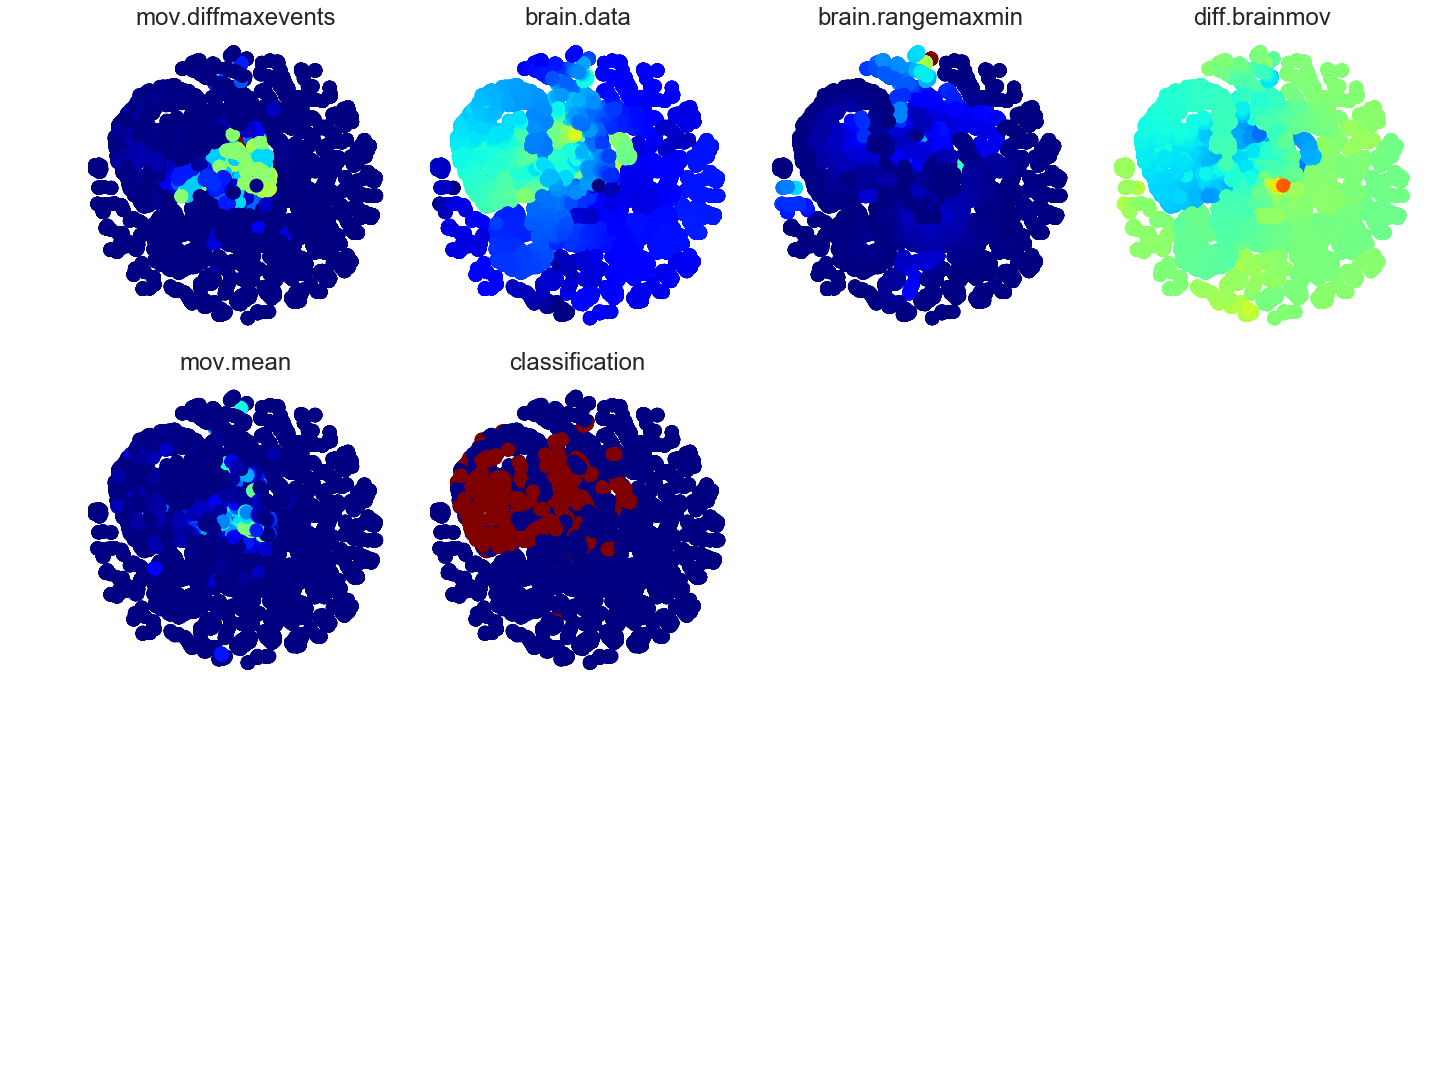

In [41]:
# from sklearn.manifold import Isomap

# isomap = Isomap(n_components=2)
# X_reduced_tsne = isomap.fit_transform(var)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(var)

fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex = True, sharey = True)
k = 0
for i in range(3):
    for j in range(4):
        if k != len(var_names):
            if var_names[k] == "classification":
                ax[i][j].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=data_big[var_names[k]], cmap='jet')
                ax[i][j].title.set_text('{0}'.format(var_names[k]))
                ax[i][j].axis('off')
                k += 1
            else:
                ax[i][j].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=var[var_names[k]], cmap='jet')
                ax[i][j].title.set_text('{0}'.format(var_names[k]))
                ax[i][j].axis('off')
                k += 1
        else:
            pass
            ax[i][j].axis('off')
plt.tight_layout()
plt.show()

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

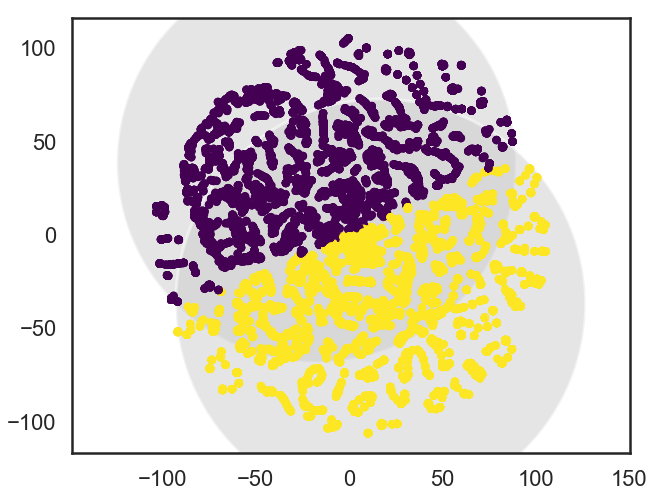

In [42]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X_reduced_tsne)
prediction = kmeans.predict(X_reduced_tsne)

colors = ["blue", "red", "orange", "yellow", "green", "purple"]

plt.figure(figsize = (10,8))
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    return labels

indices = kmeans.fit_predict(X_reduced_tsne)
plot_kmeans(kmeans, X_reduced_tsne)

In [13]:
def plot_classification(data, indices, color):
    fig = plt.figure(figsize = (20, 2))
    colors_list = ["violet", "magenta", "teal", "silver", "salmon", "pink"]
    num_color = 0;
    if (len(np.unique(indices)) > 2):
        for i in range(len(indices)):
            if (indices[i] == 0):
                plt.axvline(x = i, color = 'blue', alpha = 0.01)
            elif (indices[i] == 1):
                plt.axvline(x = i, color = 'orange')
            elif (indices[i] == 2):
                plt.axvline(x = i, color = 'green')
            elif (indices[i] == 3 ):
                plt.axvline(x = i, color = 'purple', alpha = 0.1)
            else:
                if (num_color == len(colors_list)):
                    num_color = 0
                else:
                    plt.axvline(x = i, color = colors_list[num_color], alpha = 0.01)
                    num_color += num_color
                
    else:
        for i in range(len(indices)):
            if (indices [i] == 0):
                plt.axvline(x = i, color = 'purple', alpha = 0.01)
            elif (indices [i] == 1):
                plt.axvline(x = i, color = 'yellow', alpha = 0.1)
    
    plt.plot(data, color)
    plt.plot(indices/2)
#    plt.xlim([0 , 3000])
#plot_classification(data_big["mov.mean"], indices, "black")

In [ ]:
plt.figure(figsize = (20, 2))
plt.plot(data_big["mov.mean"])
plt.plot(value)


value = smooth(data_big["mov.mean"], 30, win_type = "han")

plt.figure(figsize = (20, 2))

In [6]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from umap import UMAP

/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 549 separate connected components using meta-embedding (experimental)
  n_components
/anaconda3/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


CPU times: user 33.3 s, sys: 816 ms, total: 34.1 s
Wall time: 33.5 s


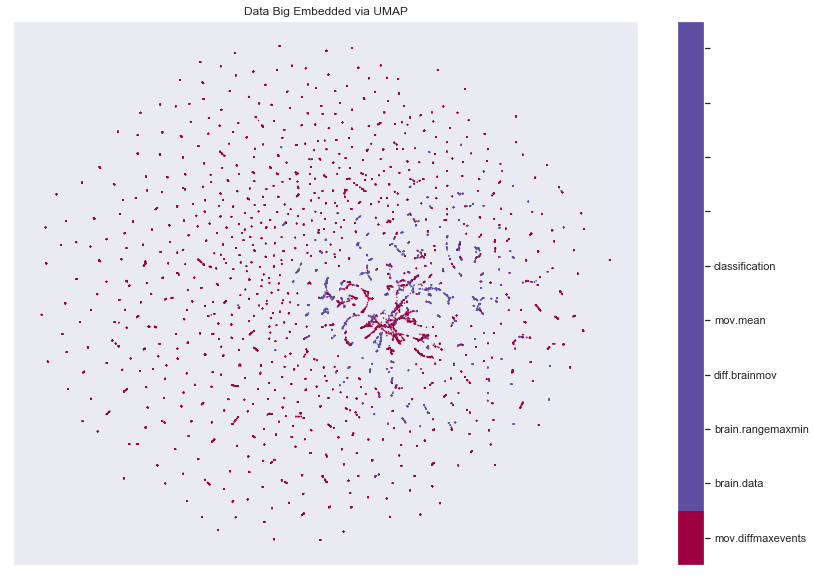

In [15]:
%%time
embedding = umap.UMAP(n_neighbors=10).fit_transform(var)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=data_big["classification"], cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(11))
cbar.set_ticklabels(var_names)
plt.title('Data Big Embedded via UMAP');

In [8]:
reducer = umap.UMAP(random_state=42)
reducer.fit(var)
embedding = reducer.transform(var)
assert(np.all(embedding == reducer.embedding_))
embedding.shape
print(embedding)

/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 378 separate connected components using meta-embedding (experimental)
  n_components


[[  1.613819   -2.4225607]
 [  1.6513817  -2.377867 ]
 [  1.6582981  -2.373995 ]
 ...
 [ 18.200573  -10.480999 ]
 [ 18.197968  -10.484245 ]
 [ 18.200262  -10.482638 ]]


0
1
2
3
4
5
6
6
6
6
6
6


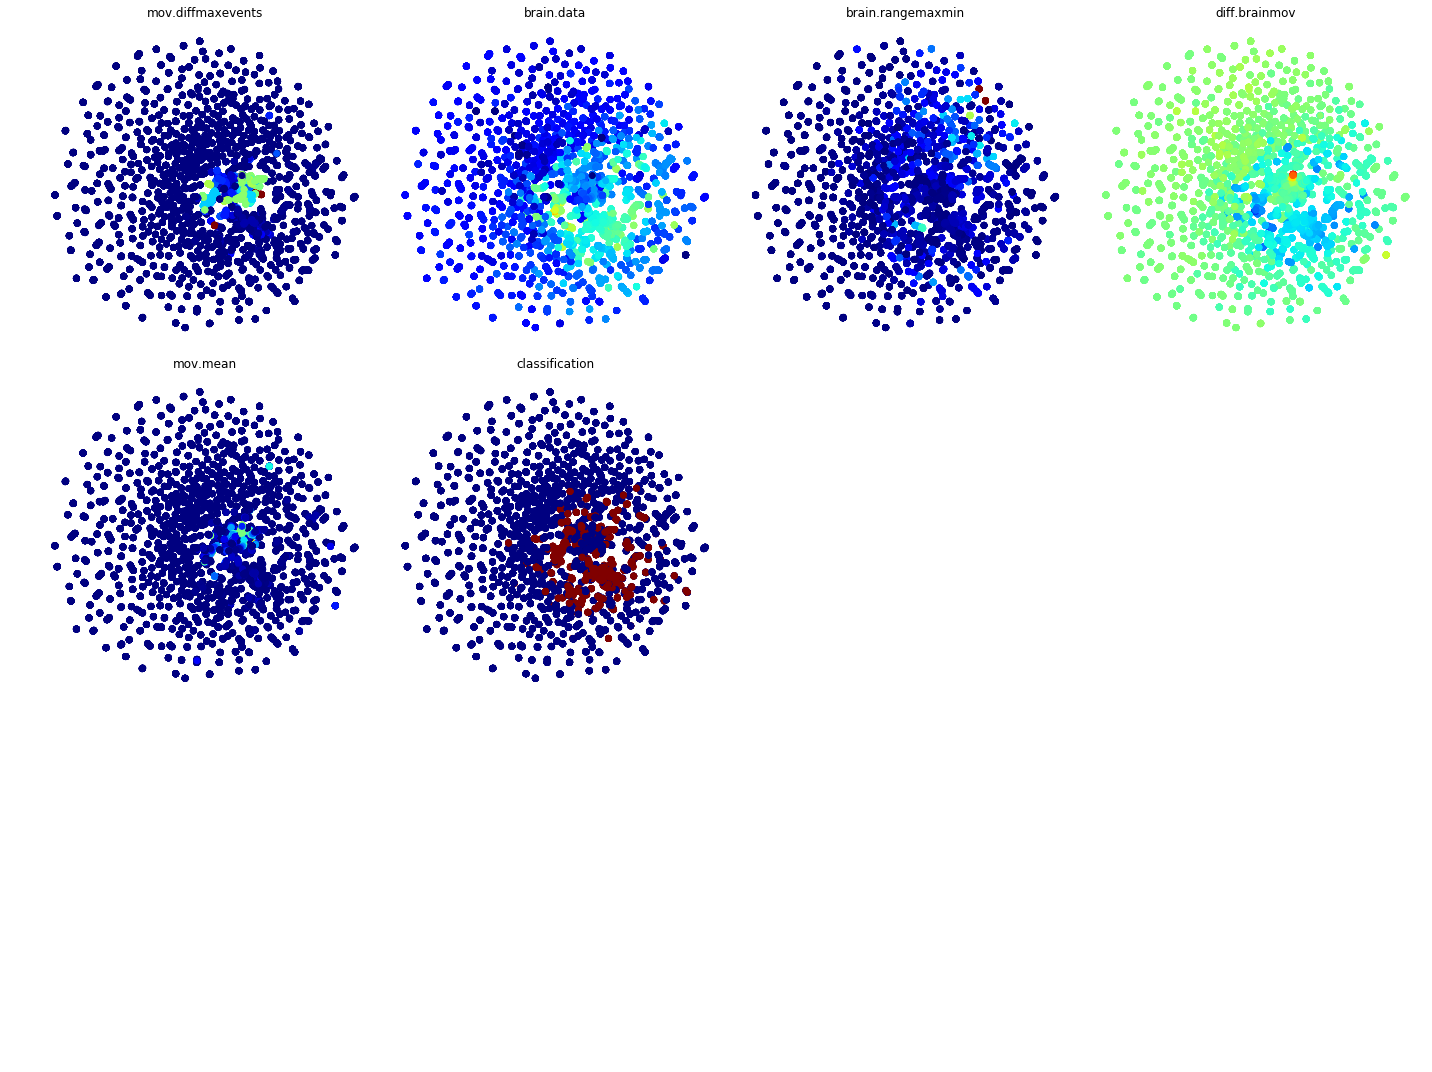

In [9]:
fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex = True, sharey = True)
k = 0
for i in range(3):
    for j in range(4):
        print(k)
        if k != len(var_names):
            if var_names[k] == "classification":
                ax[i][j].scatter(embedding[:, 0], embedding[:, 1], c=data_big[var_names[k]], cmap='jet')
                ax[i][j].title.set_text('{0}'.format(var_names[k]))
                ax[i][j].axis('off')
                k += 1
            else:
                ax[i][j].scatter(embedding[:, 0], embedding[:, 1], c=var[var_names[k]], cmap='jet')
                ax[i][j].title.set_text('{0}'.format(var_names[k]))
                ax[i][j].axis('off')
                k += 1
        else:
            pass
            ax[i][j].axis('off')
plt.tight_layout()
plt.show()

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

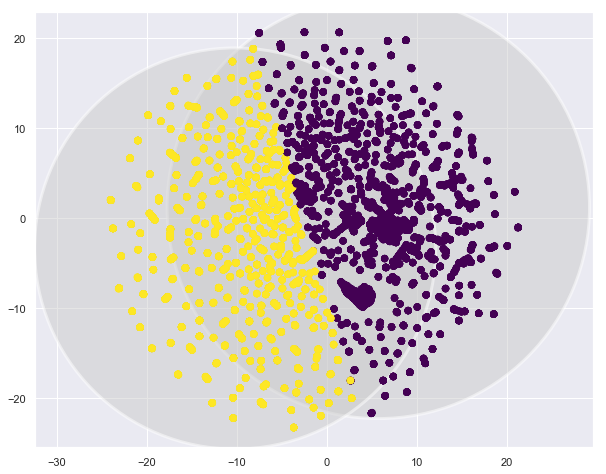

In [66]:
kmeans = KMeans(n_clusters= 2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(embedding)
prediction = kmeans.predict(embedding)

colors = ["blue", "red", "orange", "yellow", "green", "purple"]

plt.figure(figsize = (10,8))
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    return labels

indices = kmeans.fit_predict(embedding)
plot_kmeans(kmeans, embedding)

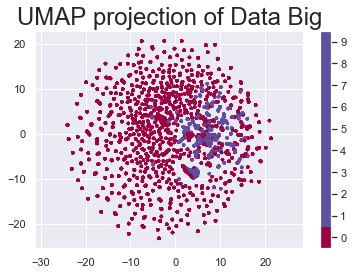

In [63]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=data_big["classification"], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of Data Big', fontsize=24);

In [10]:
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set()
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import Birch

Text(0.5, 1.0, 'Birch clustering of Data Big')

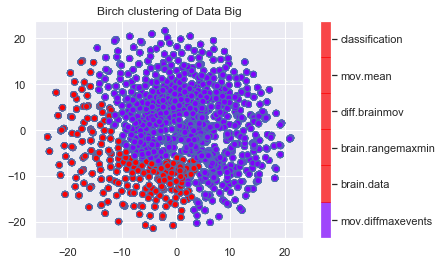

In [11]:
brc = Birch(branching_factor = 50, n_clusters = 2, threshold= 1.5)
brc.fit(embedding)
labels = brc.predict(embedding)
plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(var_names)
plt.title("Birch clustering of Data Big")

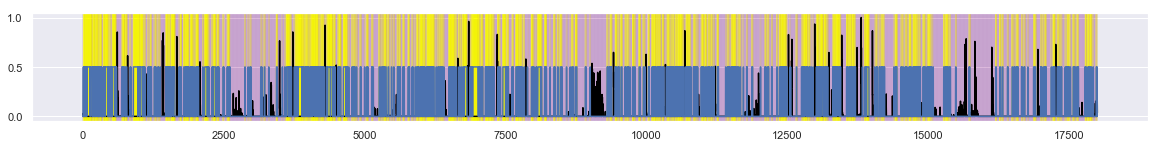

In [14]:
plot_classification(data_big["mov.mean"], labels, "black")

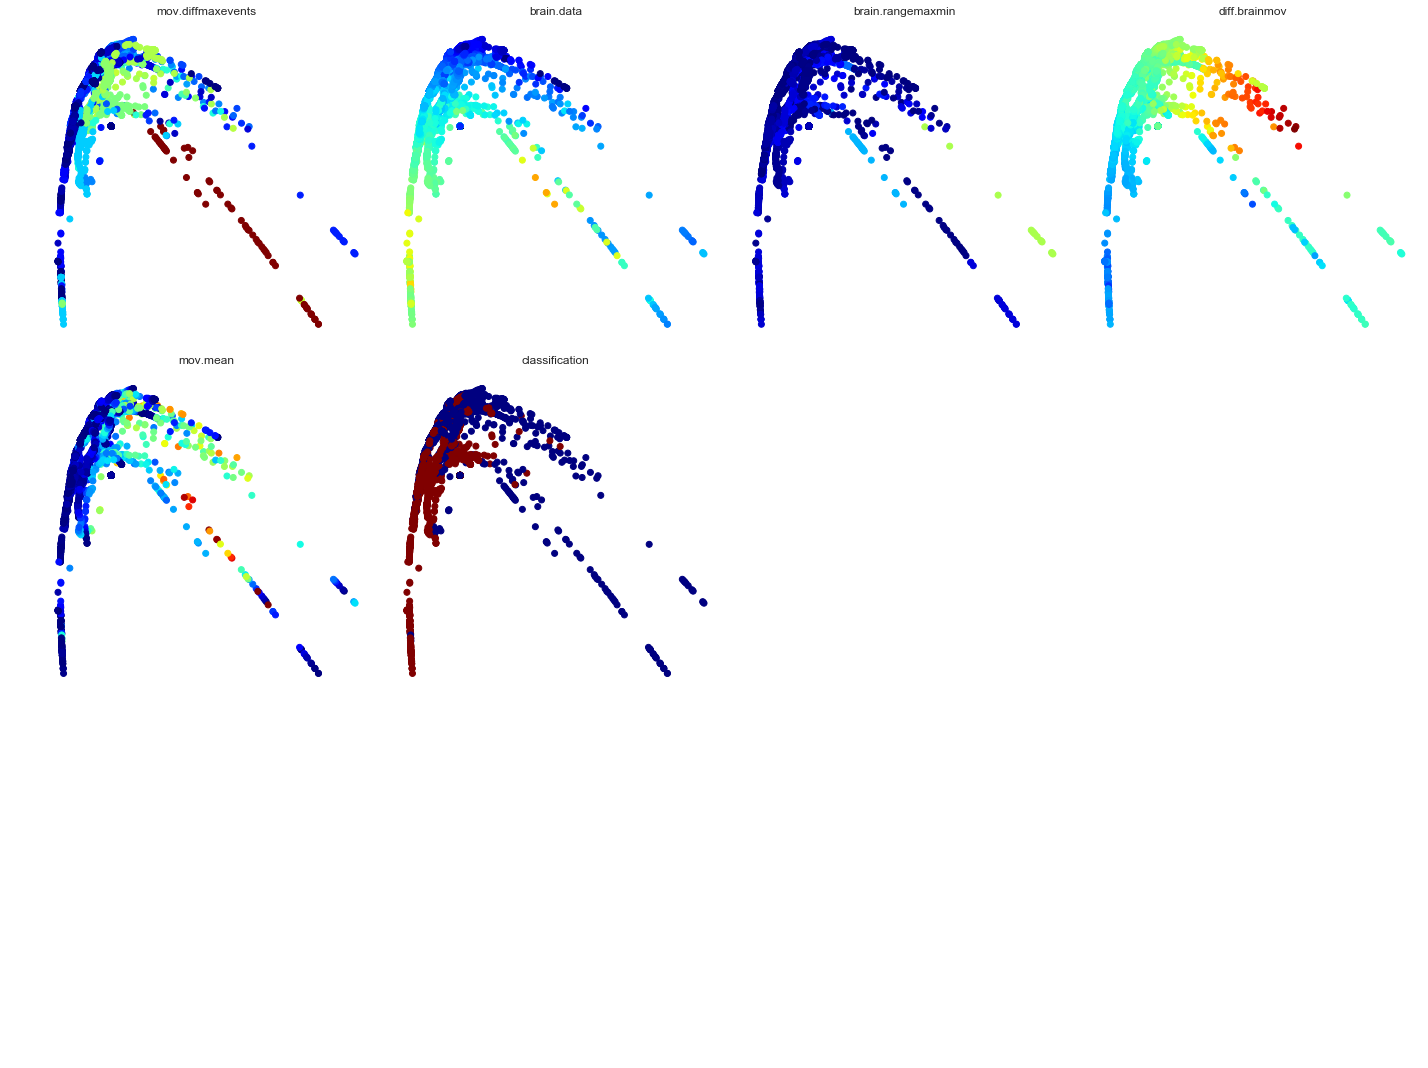

In [76]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isom = isomap.fit_transform(var)

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_reduced_tsne = tsne.fit_transform(var)

fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex = True, sharey = True)
k = 0
for i in range(3):
    for j in range(4):
        if k != len(var_names):
            if var_names[k] == "classification":
                ax[i][j].scatter(X_reduced_isom[:, 0], X_reduced_isom[:, 1], c=data_big[var_names[k]], cmap='jet')
                ax[i][j].title.set_text('{0}'.format(var_names[k]))
                ax[i][j].axis('off')
                k += 1
            else:
                ax[i][j].scatter(X_reduced_isom[:, 0], X_reduced_isom[:, 1], c=var[var_names[k]], cmap='jet')
                ax[i][j].title.set_text('{0}'.format(var_names[k]))
                ax[i][j].axis('off')
                k += 1
        else:
            pass
            ax[i][j].axis('off')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Birch clustering of Data Big')

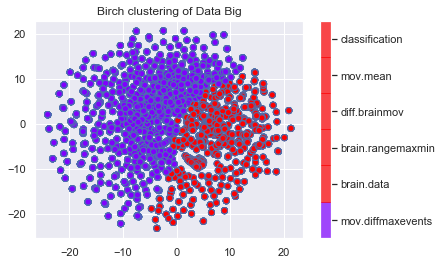

In [88]:
brc = Birch(branching_factor = 50, n_clusters = 2, threshold= 1.5)
brc.fit(embedding)
labels = brc.predict(embedding)
plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(var_names)
plt.title("Birch clustering of Data Big")

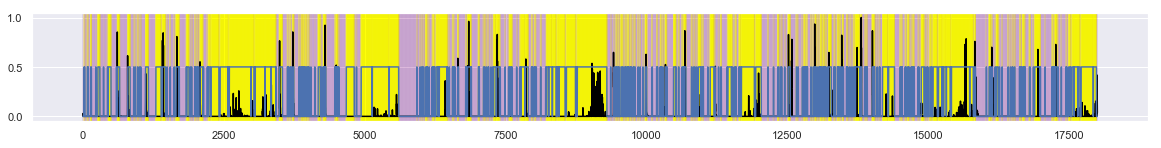

In [89]:
plot_classification(data_big["mov.mean"], labels, "black")

Automatically created module for IPython interactive environment


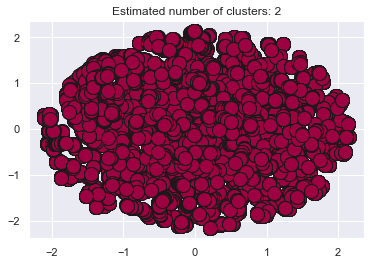

In [86]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]

X = X_reduced_tsne
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=2, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = 2#len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

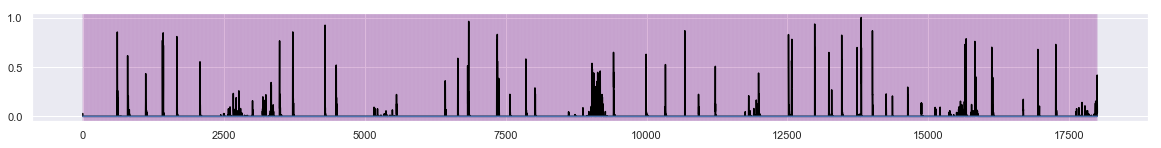

In [87]:
plot_classification(data_big["mov.mean"], labels, "black")

In [92]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()

ImportError: cannot import name 'OPTICS' from 'sklearn.cluster' (/anaconda3/lib/python3.7/site-packages/sklearn/cluster/__init__.py)